Create a file named ```.env``` in the root directory of your Jupyter notebook and add your API key from [Google AI Studio](https://aistudio.google.com/app/apikey)

In [9]:
!pip install -q -U google-genai

In [10]:
!pip install openai

In [11]:
import os
import google.generativeai as genai
from dotenv import load_dotenv

load_dotenv()

gemini_api_key = os.getenv("GEMINI_API_KEY")

In [38]:
from datetime import datetime, timedelta, timezone

# Function for formatting time in ISO 8601
def iso_format(dt):
    return dt.astimezone(timezone.utc).isoformat().replace('+00:00', 'Z')

# Task decomposition function
def decompose_task(task_description):
    prompt = f"""
        Decompose the following task into smaller, manageable subtasks. 
        For each subtask, provide a title, a brief description, an estimated time to complete in hours, 
        a complexity level (Easy, Medium, or Hard), and a due date in YYYY-MM-DD format.  
        Format the output as a JSON object with a "task" key (original task description) 
        and a "subtasks" key containing a list of subtask objects.  

        Example subtask object: 
        {{
            "title": "Research AI trends", 
            "description": "Conduct research on current AI trends", 
            "estimated_time": "8 hours", 
            "complexity": "Medium", 
            "due_date": "2024-01-29"
        }}

        Task: {task_description}
    """

    response = model.generate_content(prompt)

    return response.text



In [13]:

genai.configure(api_key=os.environ["gemini_api_key"])

# Model configuration
generation_config = {
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 40,
    "response_mime_type": "text/plain",
}

# Model initialization
model = genai.GenerativeModel(
    model_name="gemini-2.0-flash",
    generation_config=generation_config,
)

task_description = "Create popular YouTube channel"

raw_response = decompose_task(task_description)

raw_response

'```json\n{\n  "task": "Create popular YouTube channel",\n  "subtasks": [\n    {\n      "title": "Define Channel Niche and Target Audience",\n      "description": "Determine the specific topic or genre of the channel and identify the ideal viewer.",\n      "estimated_time": "4 hours",\n      "complexity": "Medium",\n      "due_date": "2024-01-29"\n    },\n    {\n      "title": "Conduct Keyword Research",\n      "description": "Identify popular and relevant keywords related to the chosen niche to optimize video titles, descriptions, and tags.",\n      "estimated_time": "6 hours",\n      "complexity": "Medium",\n      "due_date": "2024-01-30"\n    },\n    {\n      "title": "Develop Channel Branding",\n      "description": "Create a channel name, logo, banner art, and intro/outro sequence that are visually appealing and consistent with the brand.",\n      "estimated_time": "8 hours",\n      "complexity": "Medium",\n      "due_date": "2024-02-02"\n    },\n    {\n      "title": "Set up YouT

In [ ]:
import json

def print_raw_response(response):
    try:
        data = json.loads(response)

        for subtask in data.get('subtasks', []):
            try:
                due_date_str = subtask.get('due_date')
                due_date = datetime.strptime(due_date_str, '%Y-%m-%d')
                start_time = due_date.replace(hour=9, minute=0, second=0)
                estimated_time_hours = int(subtask.get('estimated_time').split(' ')[0])
                end_time = start_time + timedelta(hours=estimated_time_hours)

                subtask['calendar_event_details'] = {
                    "summary": subtask['title'],
                    "description": subtask['description'],
                    "start": iso_format(start_time),
                    "end": iso_format(end_time)
                }
            except ValueError as e:
                print(f"Ошибка парсинга даты: {e}")
                subtask['calendar_event_details'] = None

        print(json.dumps(data, indent=4))
        return data

    except json.JSONDecodeError as e:
        print(f"JSON processing error: {e}")
        print("The model's raw response:", raw_response)


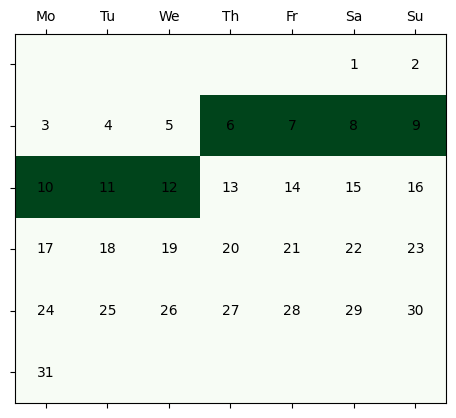

In [ ]:
import calendar
import datetime
import matplotlib.pyplot as plt
import numpy as np

def create_calendar(year, month, week_number):

    cal = calendar.Calendar(firstweekday=0)
    month_days = cal.monthdayscalendar(year, month)

    first_day_of_year = datetime.date(year, 1, 1)
    first_week_start = first_day_of_year - datetime.timedelta(days=first_day_of_year.weekday())
    start_date = first_week_start + datetime.timedelta(weeks=week_number - 1)
    end_date = start_date + datetime.timedelta(days=6)
    
  
    cal_matrix = np.array(month_days)
    mask = (cal_matrix >= start_date.day) & (cal_matrix <= end_date.day)
    

    fig, ax = plt.subplots()
    ax.matshow(mask, cmap='Greens')
    

    for i in range(len(month_days)):
        for j in range(len(month_days[i])):
            day = month_days[i][j]
            ax.text(j, i, str(day) if day != 0 else '', ha='center', va='center')
  
    ax.set_xticks(np.arange(7))
    ax.set_yticks(np.arange(len(month_days)))
    ax.set_xticklabels(['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su'])
    ax.set_yticklabels([''] * len(month_days))
    
    plt.show()

year = 2025
month = 3
week_number = 2
create_calendar(year, month, week_number)


Let's try to get our model to give a response in the required json format.

In [15]:
generation_config = {
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 40,
    "response_mime_type": "application/json",
}

model = genai.GenerativeModel(
    model_name="gemini-2.0-flash",
    generation_config=generation_config,
)

# let's change the promptness
def decompose_task(task_description):
    prompt = f"""
        Decompose the following task into smaller, manageable subtasks. 
        For each subtask, provide a title, a brief description, an estimated time to complete in hours, 
        a complexity level (Easy, Medium, or Hard), and a due date in YYYY-MM-DD format.  
        Format the output as a JSON object with a "task" key (original task description) 
        and a "subtasks" key containing a list of subtask objects.  

        Example subtask object: 
        {{
            "title": str, 
            "description": str, 
            "estimated_time": str, 
            "complexity": str, 
            "due_date": data
        }}

        Task: {task_description}
    """

    response = model.generate_content(prompt)

    return response.text


raw_response = decompose_task(task_description)
raw_response

'{\n  "task": "Create popular YouTube channel",\n  "subtasks": [\n    {\n      "title": "Market Research & Niche Selection",\n      "description": "Identify a profitable niche with a dedicated audience and low competition. Research trending topics and popular YouTube channels in potential niches.",\n      "estimated_time": "10",\n      "complexity": "Medium",\n      "due_date": "2024-01-20"\n    },\n    {\n      "title": "Channel Branding & Setup",\n      "description": "Choose a channel name, create a logo, design channel art, and write a compelling channel description. Set up all necessary channel settings.",\n      "estimated_time": "8",\n      "complexity": "Easy",\n      "due_date": "2024-01-27"\n    },\n    {\n      "title": "Content Planning & Strategy",\n      "description": "Develop a content calendar with video ideas, target keywords, and posting schedule. Plan for various video formats (tutorials, reviews, vlogs, etc.)",\n      "estimated_time": "12",\n      "complexity": "M

In [39]:
print_raw_response(raw_response)

{
    "task": "Create popular YouTube channel",
    "subtasks": [
        {
            "title": "Market Research & Niche Selection",
            "description": "Identify a profitable niche with a dedicated audience and low competition. Research trending topics and popular YouTube channels in potential niches.",
            "estimated_time": "10",
            "complexity": "Medium",
            "due_date": "2024-01-20",
            "calendar_event_details": {
                "summary": "Market Research & Niche Selection",
                "description": "Identify a profitable niche with a dedicated audience and low competition. Research trending topics and popular YouTube channels in potential niches.",
                "start": "2024-01-20T06:00:00Z",
                "end": "2024-01-20T16:00:00Z"
            }
        },
        {
            "title": "Channel Branding & Setup",
            "description": "Choose a channel name, create a logo, design channel art, and write a compelling 

{'task': 'Create popular YouTube channel',
 'subtasks': [{'title': 'Market Research & Niche Selection',
   'description': 'Identify a profitable niche with a dedicated audience and low competition. Research trending topics and popular YouTube channels in potential niches.',
   'estimated_time': '10',
   'complexity': 'Medium',
   'due_date': '2024-01-20',
   'calendar_event_details': {'summary': 'Market Research & Niche Selection',
    'description': 'Identify a profitable niche with a dedicated audience and low competition. Research trending topics and popular YouTube channels in potential niches.',
    'start': '2024-01-20T06:00:00Z',
    'end': '2024-01-20T16:00:00Z'}},
  {'title': 'Channel Branding & Setup',
   'description': 'Choose a channel name, create a logo, design channel art, and write a compelling channel description. Set up all necessary channel settings.',
   'estimated_time': '8',
   'complexity': 'Easy',
   'due_date': '2024-01-27',
   'calendar_event_details': {'summa

### Change promt text

In [40]:
task_description = "promote your own YouTube channel on embedded microcontroller development"
prompt = f"""
       Decompose the following task into smaller, manageable subtasks.  
        For each subtask, decompose it further into microtasks where possible.  
        Ensure each subtask and microtask has:
        - A title
        - A brief description
        - An estimated time to complete (in hours)
        - A complexity level (Easy, Medium, or Hard)
        - A due date in YYYY-MM-DD format  

        Format the output as a JSON object with:
        - "task" key (original task description)
        - "subtasks" key containing a list of subtask objects
        - Each subtask can contain a "microtasks" key (list of microtask objects)  

        Example JSON output: 
        {{
            "task": "",
            "subtasks": [
                {{
                    "title": "",
                    "description": "",
                    "estimated_time": "4",
                    "complexity": "Medium",
                    "due_date": "2024-11-01",
                    "microtasks": [
                        {{
                            "title": "",
                            "description": "",
                            "estimated_time": "2",
                            "complexity": "Easy",
                            "due_date": "2024-10-30"
                        }},
                        {{
                            "title": "",
                            "description": "",
                            "estimated_time": "2",
                            "complexity": "Medium",
                            "due_date": "2024-10-31"
                        }}
                    ]
                }}
            ]
        }}
        Task: {task_description}
    """
response = model.generate_content(prompt)

In [41]:
data_json = print_raw_response(response.text)

{
    "task": "promote your own YouTube channel on embedded microcontroller development",
    "subtasks": [
        {
            "title": "Define Target Audience and Channel Value Proposition",
            "description": "Clearly define who the channel is for and what unique value it offers to viewers.",
            "estimated_time": "4",
            "complexity": "Medium",
            "due_date": "2024-12-01",
            "microtasks": [
                {
                    "title": "Identify Target Audience Demographics and Interests",
                    "description": "Research the demographics, skill levels, and interests of potential viewers interested in embedded microcontroller development.",
                    "estimated_time": "2",
                    "complexity": "Easy",
                    "due_date": "2024-11-28"
                },
                {
                    "title": "Define Unique Selling Points (USPs)",
                    "description": "Determine what ma

### Let's create a graph event for each subtask and microtask

In [ ]:
!pip install -U matplotlib pandas

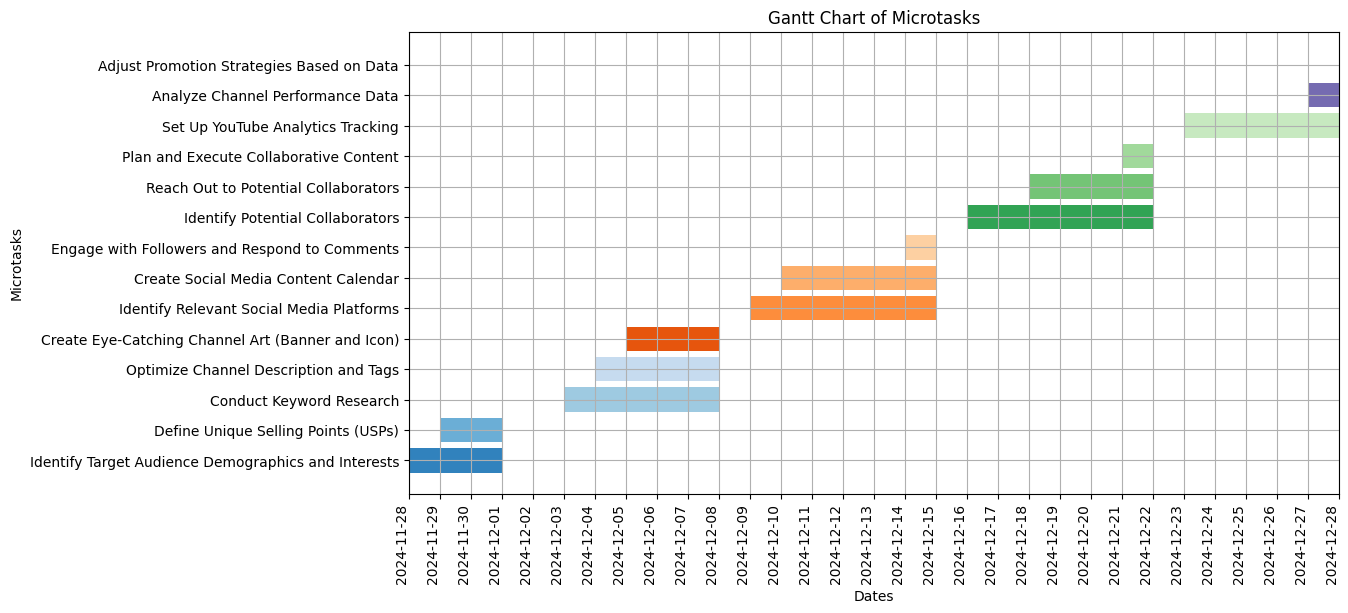

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(12, 6))

for idx, row in df.iterrows():
    start_date = row['Task Due Date']
    end_date = row['Microtask Due Date']
    color = plt.colormaps.get_cmap('tab20c')(idx % 20)
    ax.barh(row['Microtask Title'], (end_date - start_date).days, left=start_date, color=color)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

start_date = df['Microtask Due Date'].min() # - pd.Timedelta(days=3)  
end_date = df['Microtask Due Date'].max() # + pd.Timedelta(days=3)
ax.set_xlim(start_date, end_date)

plt.setp(ax.get_xticklabels(), rotation=90, ha="right")

plt.xlabel('Dates')
plt.ylabel('Microtasks')
plt.title('Gantt Chart of Microtasks')
plt.grid(True)

plt.show()

In [59]:
subtasks_list = []

for task in data_json['subtasks']:
    for microtask in task['microtasks']:
        subtasks_list.append({
            'Task Title': task['title'],
            'Task Description': task['description'],
            'Task Estimated Time': task['estimated_time'],
            'Task Complexity': task['complexity'],
            'Task Due Date': task['due_date'],
            'Microtask Title': microtask['title'],
            'Microtask Description': microtask['description'],
            'Microtask Estimated Time': microtask['estimated_time'],
            'Microtask Complexity': microtask['complexity'],
            'Microtask Due Date': microtask['due_date']
        })

df = pd.DataFrame(subtasks_list)

df['Task Due Date'] = pd.to_datetime(df['Task Due Date'])
df['Microtask Due Date'] = pd.to_datetime(df['Microtask Due Date'])

In [60]:
df

,Task Title,Task Description,Task Estimated Time,Task Complexity,Task Due Date,Microtask Title,Microtask Description,Microtask Estimated Time,Microtask Complexity,Microtask Due Date
0,Define Target Audience and Channel Value Propo...,Clearly define who the channel is for and what...,4,Medium,2024-12-01,Identify Target Audience Demographics and Inte...,"Research the demographics, skill levels, and i...",2,Easy,2024-11-28
1,Define Target Audience and Channel Value Propo...,Clearly define who the channel is for and what...,4,Medium,2024-12-01,Define Unique Selling Points (USPs),Determine what makes your channel different fr...,2,Medium,2024-11-29
2,Optimize YouTube Channel for Discovery,Improve channel visibility through keyword res...,8,Medium,2024-12-08,Conduct Keyword Research,Identify relevant keywords related to embedded...,3,Medium,2024-12-03
3,Optimize YouTube Channel for Discovery,Improve channel visibility through keyword res...,8,Medium,2024-12-08,Optimize Channel Description and Tags,Incorporate relevant keywords into the channel...,2,Easy,2024-12-04
4,Optimize YouTube Channel for Discovery,Improve channel visibility through keyword res...,8,Medium,2024-12-08,Create Eye-Catching Channel Art (Banner and Icon),Design a visually appealing channel banner and...,3,Medium,2024-12-05
5,Promote Channel on Social Media Platforms,Share YouTube content on relevant social media...,6,Medium,2024-12-15,Identify Relevant Social Media Platforms,Determine which social media platforms are mos...,1,Easy,2024-12-09
6,Promote Channel on Social Media Platforms,Share YouTube content on relevant social media...,6,Medium,2024-12-15,Create Social Media Content Calendar,Plan a schedule for sharing YouTube videos and...,2,Medium,2024-12-10
7,Promote Channel on Social Media Platforms,Share YouTube content on relevant social media...,6,Medium,2024-12-15,Engage with Followers and Respond to Comments,"Actively participate in conversations, answer ...",3,Medium,2024-12-14
8,Collaborate with Other YouTubers and Influencers,Partner with other YouTubers or influencers in...,8,Hard,2024-12-22,Identify Potential Collaborators,Research other YouTubers and influencers who c...,2,Medium,2024-12-16
9,Collaborate with Other YouTubers and Influencers,Partner with other YouTubers or influencers in...,8,Hard,2024-12-22,Reach Out to Potential Collaborators,Contact potential collaborators and propose co...,3,Medium,2024-12-18


In [51]:
from IPython.display import Markdown, display

grouped_df = df.groupby('Task Title')

def color_complexity(complexity):
    if complexity == "Easy":
        return 'green'
    elif complexity == "Medium":
        return 'orange'
    elif complexity == "Hard":
        return 'red'
    else:
        return 'blue'

output = ""
for task_title, group in grouped_df:
    group = group.sort_values(by='Task Due Date')

    start_date = group['Task Due Date'].min().date()
    end_date = group['Task Due Date'].max().date()
    output += f"### {task_title}\n"
    output += f"**Duration:** {group['Microtask Due Date'].min().date()} - {group['Microtask Due Date'].max().date()} \n"
    output += f"**Microtasks:**\n"
    for index, row in group.iterrows():
        color = color_complexity(row['Microtask Complexity'])
        output += f"- **{row['Microtask Title']}** (_Complexity:_ <span style='color:{color}'>{row['Microtask Complexity']}</span>)\n"
        output += f"  - Description: {row['Microtask Description']}\n"
        output += f"  - Start Date: {row['Task Due Date']}\n"
        output += f"  - End Date: {row['Microtask Due Date']}\n"
    output += "\n"

from IPython.display import Markdown, display
display(Markdown(output))

### Collaborate with Other YouTubers and Influencers
**Duration:** 2024-12-16 - 2024-12-21 
**Microtasks:**
- **Identify Potential Collaborators** (_Complexity:_ <span style='color:orange'>Medium</span>)
  - Description: Research other YouTubers and influencers who create content related to embedded microcontrollers.
  - Start Date: 2024-12-22 00:00:00
  - End Date: 2024-12-16 00:00:00
- **Reach Out to Potential Collaborators** (_Complexity:_ <span style='color:orange'>Medium</span>)
  - Description: Contact potential collaborators and propose collaboration ideas that would benefit both channels.
  - Start Date: 2024-12-22 00:00:00
  - End Date: 2024-12-18 00:00:00
- **Plan and Execute Collaborative Content** (_Complexity:_ <span style='color:red'>Hard</span>)
  - Description: Work with collaborators to create engaging and informative content that will appeal to both audiences.
  - Start Date: 2024-12-22 00:00:00
  - End Date: 2024-12-21 00:00:00

### Define Target Audience and Channel Value Proposition
**Duration:** 2024-11-28 - 2024-11-29 
**Microtasks:**
- **Identify Target Audience Demographics and Interests** (_Complexity:_ <span style='color:green'>Easy</span>)
  - Description: Research the demographics, skill levels, and interests of potential viewers interested in embedded microcontroller development.
  - Start Date: 2024-12-01 00:00:00
  - End Date: 2024-11-28 00:00:00
- **Define Unique Selling Points (USPs)** (_Complexity:_ <span style='color:orange'>Medium</span>)
  - Description: Determine what makes your channel different from other embedded microcontroller development channels. Focus on specific expertise, teaching style, or unique content.
  - Start Date: 2024-12-01 00:00:00
  - End Date: 2024-11-29 00:00:00

### Optimize YouTube Channel for Discovery
**Duration:** 2024-12-03 - 2024-12-05 
**Microtasks:**
- **Conduct Keyword Research** (_Complexity:_ <span style='color:orange'>Medium</span>)
  - Description: Identify relevant keywords related to embedded microcontrollers, development platforms, and specific projects.
  - Start Date: 2024-12-08 00:00:00
  - End Date: 2024-12-03 00:00:00
- **Optimize Channel Description and Tags** (_Complexity:_ <span style='color:green'>Easy</span>)
  - Description: Incorporate relevant keywords into the channel description and tags to improve search ranking.
  - Start Date: 2024-12-08 00:00:00
  - End Date: 2024-12-04 00:00:00
- **Create Eye-Catching Channel Art (Banner and Icon)** (_Complexity:_ <span style='color:orange'>Medium</span>)
  - Description: Design a visually appealing channel banner and icon that represent the channel's content and brand.
  - Start Date: 2024-12-08 00:00:00
  - End Date: 2024-12-05 00:00:00

### Promote Channel on Social Media Platforms
**Duration:** 2024-12-09 - 2024-12-14 
**Microtasks:**
- **Identify Relevant Social Media Platforms** (_Complexity:_ <span style='color:green'>Easy</span>)
  - Description: Determine which social media platforms are most popular among embedded microcontroller enthusiasts (e.g., LinkedIn, Reddit, Twitter, specialized forums).
  - Start Date: 2024-12-15 00:00:00
  - End Date: 2024-12-09 00:00:00
- **Create Social Media Content Calendar** (_Complexity:_ <span style='color:orange'>Medium</span>)
  - Description: Plan a schedule for sharing YouTube videos and other relevant content on social media.
  - Start Date: 2024-12-15 00:00:00
  - End Date: 2024-12-10 00:00:00
- **Engage with Followers and Respond to Comments** (_Complexity:_ <span style='color:orange'>Medium</span>)
  - Description: Actively participate in conversations, answer questions, and build relationships with followers on social media.
  - Start Date: 2024-12-15 00:00:00
  - End Date: 2024-12-14 00:00:00

### Track and Analyze Channel Performance
**Duration:** 2024-12-23 - 2024-12-28 
**Microtasks:**
- **Set Up YouTube Analytics Tracking** (_Complexity:_ <span style='color:green'>Easy</span>)
  - Description: Ensure that YouTube Analytics is properly configured to track relevant metrics.
  - Start Date: 2024-12-29 00:00:00
  - End Date: 2024-12-23 00:00:00
- **Analyze Channel Performance Data** (_Complexity:_ <span style='color:orange'>Medium</span>)
  - Description: Regularly review YouTube Analytics data to identify trends and areas for improvement.
  - Start Date: 2024-12-29 00:00:00
  - End Date: 2024-12-27 00:00:00
- **Adjust Promotion Strategies Based on Data** (_Complexity:_ <span style='color:orange'>Medium</span>)
  - Description: Modify promotion strategies based on the insights gained from analyzing channel performance data.
  - Start Date: 2024-12-29 00:00:00
  - End Date: 2024-12-28 00:00:00



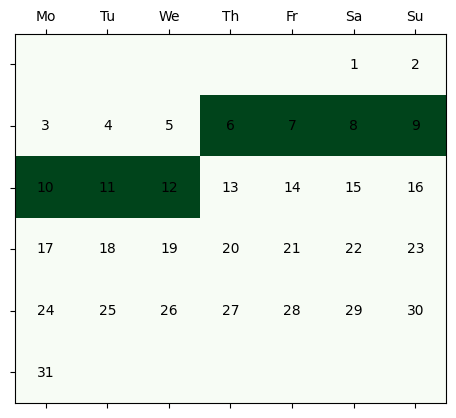

In [ ]:
import calendar
import datetime
import matplotlib.pyplot as plt
import numpy as np

def create_calendar(year, month, week_number):

    cal = calendar.Calendar(firstweekday=0)
    month_days = cal.monthdayscalendar(year, month)

    first_day_of_year = datetime.date(year, 1, 1)
    first_week_start = first_day_of_year - datetime.timedelta(days=first_day_of_year.weekday())
    start_date = first_week_start + datetime.timedelta(weeks=week_number - 1)
    end_date = start_date + datetime.timedelta(days=6)
    
  
    cal_matrix = np.array(month_days)
    mask = (cal_matrix >= start_date.day) & (cal_matrix <= end_date.day)
    

    fig, ax = plt.subplots()
    ax.matshow(mask, cmap='Greens')
    

    for i in range(len(month_days)):
        for j in range(len(month_days[i])):
            day = month_days[i][j]
            ax.text(j, i, str(day) if day != 0 else '', ha='center', va='center')
  
    ax.set_xticks(np.arange(7))
    ax.set_yticks(np.arange(len(month_days)))
    ax.set_xticklabels(['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su'])
    ax.set_yticklabels([''] * len(month_days))
    
    plt.show()

year = 2025
month = 3
week_number = 2
create_calendar(year, month, week_number)


In [24]:
import calendar 

yy = 2017
mm = 11
print(calendar.month(yy, mm)) 


   November 2017
Mo Tu We Th Fr Sa Su
       1  2  3  4  5
 6  7  8  9 10 11 12
13 14 15 16 17 18 19
20 21 22 23 24 25 26
27 28 29 30



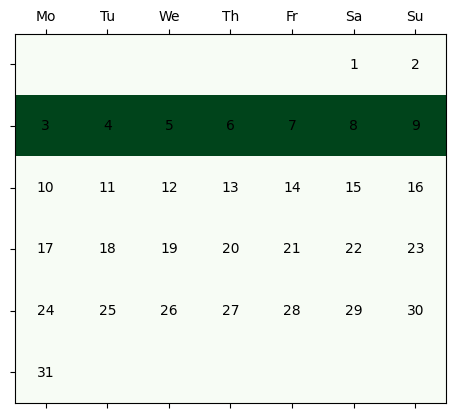

In [61]:
import calendar
import datetime
import matplotlib.pyplot as plt
import numpy as np

def create_calendar(year, month, week_number):

    cal = calendar.Calendar(firstweekday=0)
    month_days = cal.monthdayscalendar(year, month)
    
 
    first_day_of_year = datetime.date(year, 1, 1)
    first_week_start = first_day_of_year - datetime.timedelta(days=first_day_of_year.weekday())
    start_date = first_week_start + datetime.timedelta(weeks=week_number - 1)
    end_date = start_date + datetime.timedelta(days=6)
    

    cal_matrix = np.array(month_days)
    mask = (cal_matrix >= start_date.day) & (cal_matrix <= end_date.day)
    

    fig, ax = plt.subplots()
    ax.matshow(mask, cmap='Greens')
    
    for i in range(len(month_days)):
        for j in range(len(month_days[i])):
            day = month_days[i][j]
            ax.text(j, i, str(day) if day != 0 else '', ha='center', va='center')
    
    ax.set_xticks(np.arange(7))
    ax.set_yticks(np.arange(len(month_days)))
    ax.set_xticklabels(['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su'])
    ax.set_yticklabels([''] * len(month_days))
    
    plt.show()

# Пример использования
year = 2025
month = 3
week_number = 10
create_calendar(year, month, week_number)


In [52]:
selected_columns = ['Task Title', 'Microtask Title', 'Task Due Date', 'Microtask Due Date']
df_selected = df.loc[:, selected_columns]

df_selected


,Task Title,Microtask Title,Task Due Date,Microtask Due Date
0,Define Target Audience and Channel Value Propo...,Identify Target Audience Demographics and Inte...,2024-12-01,2024-11-28
1,Define Target Audience and Channel Value Propo...,Define Unique Selling Points (USPs),2024-12-01,2024-11-29
2,Optimize YouTube Channel for Discovery,Conduct Keyword Research,2024-12-08,2024-12-03
3,Optimize YouTube Channel for Discovery,Optimize Channel Description and Tags,2024-12-08,2024-12-04
4,Optimize YouTube Channel for Discovery,Create Eye-Catching Channel Art (Banner and Icon),2024-12-08,2024-12-05
5,Promote Channel on Social Media Platforms,Identify Relevant Social Media Platforms,2024-12-15,2024-12-09
6,Promote Channel on Social Media Platforms,Create Social Media Content Calendar,2024-12-15,2024-12-10
7,Promote Channel on Social Media Platforms,Engage with Followers and Respond to Comments,2024-12-15,2024-12-14
8,Collaborate with Other YouTubers and Influencers,Identify Potential Collaborators,2024-12-22,2024-12-16
9,Collaborate with Other YouTubers and Influencers,Reach Out to Potential Collaborators,2024-12-22,2024-12-18


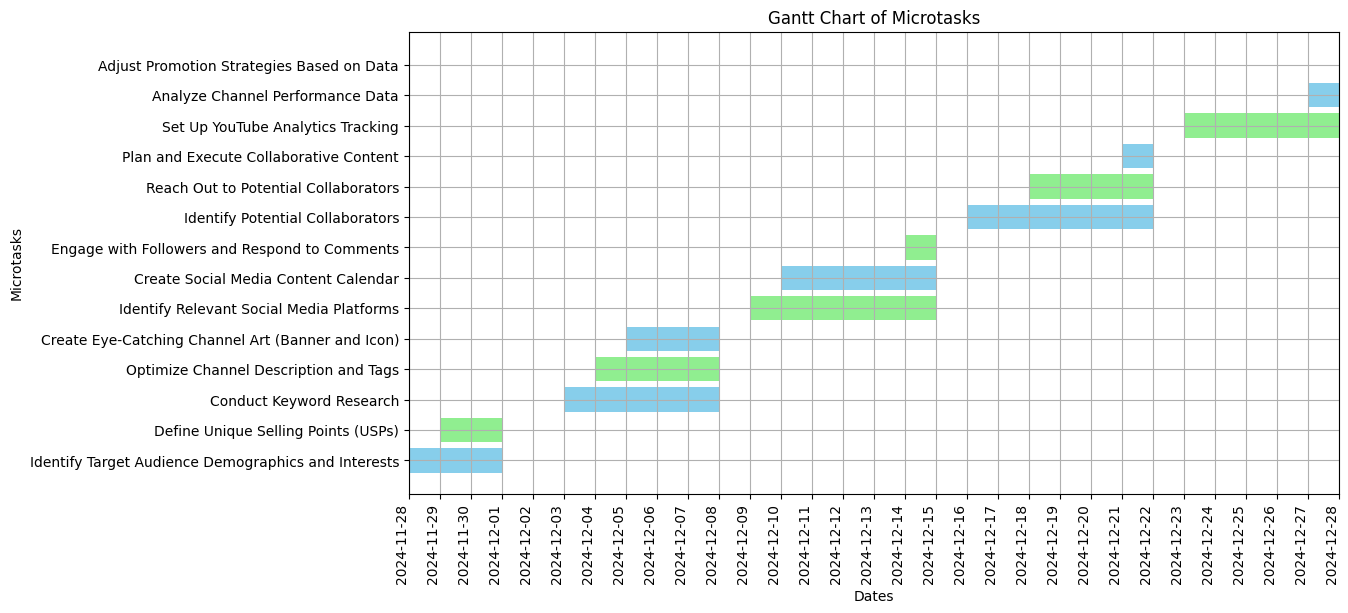